In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.autograd import Variable
from torchvision import transforms

In [79]:
from adjustText import adjust_text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

import rbm_qst
import rbm_classic

import utils
import utils_phases
import paper_functions

In [367]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(Encoder, self).__init__()
        self.D_out = D_out
        self.linear1 = torch.nn.Linear(D_in, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return x


class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.D_in = D_in
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        self.linears = [torch.nn.Linear(D_out, D_out) for _ in range(3)]

    def forward(self, x):
        x = F.relu(self.linear1(x))
        for i in range(3):
            x = self.linears[i](x)
        x = F.sigmoid(self.linear2(x))
        return x


class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(encoder.D_out, decoder.D_in)
        self._enc_log_sigma = torch.nn.Linear(encoder.D_out, decoder.D_in)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)
    
    
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

In [368]:
num_units = 5
num_samples = 1000

thetas = utils_phases.random_phases(num_units)
print("Thetas:", thetas)

quantum_system = [(0,0,0,0,1),
                  (0,0,0,1,0),
                  (0,0,1,0,0),
                  (0,1,0,0,0),
                  (1,0,0,0,0)]

amplitudes = [1 / np.sqrt(num_units)] * num_units
phases = thetas

main_basis = utils_phases.U_ZZ(num_units)

dataset = utils.generate_phases_dataset(quantum_system, amplitudes, phases, num_units, num_samples)
print(dataset.keys())

Thetas: [5.24560682 0.90481394 3.80233053 4.50735772 2.97381337]
dict_keys(['IIIII', 'HHIII', 'IHHII', 'IIHHI', 'IIIHH', 'HKIII', 'IHKII', 'IIHKI', 'IIIHK'])


In [369]:
operations = "IIIII"
to_train = dataset[operations]

input_dim = num_units
batch_size = 32

to_train = torch.Tensor(to_train)
occurrs, data_hist = utils.dataset_to_hist(to_train)
print("data_hist:", data_hist)
dataloader = torch.utils.data.DataLoader(to_train, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
print('Number of samples: ', len(to_train))

data_hist: [[0 1 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]
Number of samples:  1000


In [370]:
sum([parameter.numel() for parameter in vae.parameters()])

180

In [371]:
encoder = Encoder(input_dim, 5)
decoder = Decoder(5, 5, input_dim)
vae = VAE(encoder, decoder)

criterion = nn.MSELoss()

lr = 1e-2
epochs = 300
log_interval = 10
l = None

optimizer = optim.Adam(vae.parameters(), lr=lr)

for epoch in range(epochs):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    for i, data in enumerate(dataloader, 0):
        inputs = data
        inputs = Variable(inputs)
        optimizer.zero_grad()
        dec = vae(inputs)
        ll = latent_loss(vae.z_mean, vae.z_sigma)
        loss = F.binary_cross_entropy(dec, inputs, size_average=False) + 4 * ll
        loss.backward()
        optimizer.step()
        l = loss.data[0]

    if epoch % log_interval == 0:
        if epoch > 60:
            lr = 1e-3
        print("{}/{}".format(epoch, epochs), l)

0/300 21.66913414001465
10/300 13.374622344970703
20/300 12.893253326416016
30/300 10.100536346435547
40/300 7.312313556671143
50/300 5.414168357849121
60/300 5.622803688049316
70/300 5.358150959014893
80/300 5.4192280769348145
90/300 4.928457260131836
100/300 4.909191608428955
110/300 4.681161880493164
120/300 5.646295547485352
130/300 4.434757709503174
140/300 4.622013568878174
150/300 4.548849105834961
160/300 4.482666015625
170/300 4.765876293182373
180/300 4.377144813537598
190/300 4.65690803527832
200/300 4.243295192718506
210/300 4.285311698913574
220/300 4.488174915313721
230/300 4.3762898445129395
240/300 4.292900085449219
250/300 4.121121406555176
260/300 4.027081489562988
270/300 4.199202537536621
280/300 4.3354034423828125
290/300 4.1941328048706055


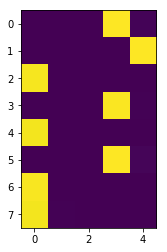

In [372]:
# plt.imshow(inputs.data.numpy())
# plt.show()

plt.imshow(vae(inputs).data.numpy())
plt.show()

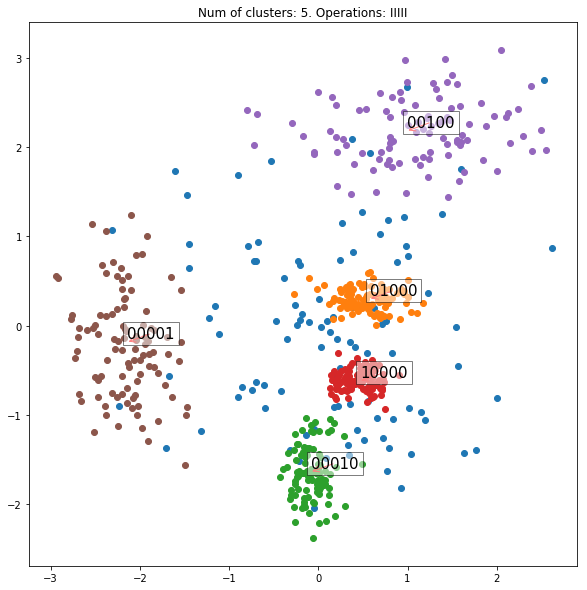

In [373]:
sampled = list()
num_samples = 100
texts = list()

coordx = 0
coordy = 1

for state in data_hist:
    tmp = vae.encoder(Variable(torch.Tensor(state.astype(float))))
    texts.append((''.join(map(str, state)), vae._enc_mu(tmp).data.numpy()))
    tmp_sampled = np.array([vae._sample_latent(tmp).data.numpy() for _ in range(num_samples)])
    x = tmp_sampled[:, coordx]
    y = tmp_sampled[:, coordy]
    sampled.append((x, y))
    
    
rand_latent = torch.randn(num_samples, 2)
rlatentnumpy = rand_latent.numpy()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(rlatentnumpy[:, 0], rlatentnumpy[:, 1])

for i in sampled:
    ax.scatter(i[0], i[1])
    
# ax.set_title('Num of Visibles: 5. States: 10000, 01000, 00100, ...')
ax.set_title("Num of clusters: {}. Operations: {}".format(len(data_hist), operations))
ax.set_aspect("equal")

plot_text = [plt.text(text[1][coordx], text[1][coordy], text[0],
                      ha="center", va="center", bbox={"facecolor": "white", "alpha": 0.5},
                      fontsize=15) for text in texts]
adjust_text(plot_text, arrowprops=dict(arrowstyle='->', color='red'))

plt.show()

In [374]:
rand_latent = torch.randn(10000, 5)
rand_latent = Variable(rand_latent)
decoded = vae.decoder(rand_latent)

# plt.imshow(decoded.data.numpy())
# plt.show()

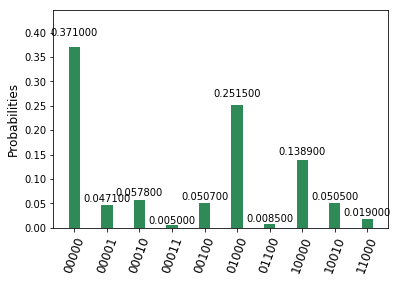

In [375]:
import collections
from qiskit.tools.visualization import plot_histogram


cnt = collections.Counter([''.join(map(str, (state > 0.5).astype(int))) for state in decoded.data.numpy()])
cnt = dict(cnt)

plot_histogram(cnt)

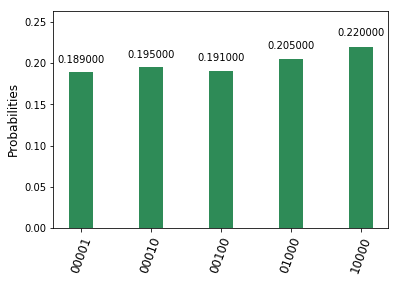

In [376]:
cnt = collections.Counter([''.join(map(str, state.astype(int))) for state in to_train.numpy()])
cnt = dict(cnt)
plot_histogram(cnt)